In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
zip_file_path = '/content/flower.zip'
extract_path = 'Flowers'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
data_dir = '/content/Flowers'
image_size = (64, 64)  # Resize images to 64x64
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True
)

Found 330 images belonging to 2 classes.


In [4]:
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(image_size + (3,)), activation='tanh'))
    model.add(layers.Reshape(image_size + (3,)))
    return model

def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=image_size + (3,)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [5]:
z = layers.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

gan = models.Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [10]:
def train_gan(epochs, batch_size, sample_interval):
    for epoch in range(epochs):
        # Train Discriminator
        imgs = next(train_generator)  # Get the next batch of images from the generator

        # Ensure imgs has the correct shape
        if imgs.shape[0] != batch_size:
            print(f"Warning: Expected batch size {batch_size}, but got {imgs.shape[0]}. Adjusting batch size.")
            imgs = imgs[:batch_size]  # Adjust to match batch size

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        # Train on real images
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((imgs.shape[0], 1)))  # Real labels
        # Train on fake images
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))  # Fake labels

        # Average the losses
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])  # Loss
        d_acc = 0.5 * (d_loss_real[1] + d_loss_fake[1])  # Accuracy

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Labels for generator

        # Print the progress
        if epoch % sample_interval == 0:
            # g_loss is a float, not a list, so remove [0]
            print(f"{epoch} [D loss: {d_loss:.4f}, acc.: {100 * d_acc:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images(epoch)

In [11]:
def sample_images(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot the generated images
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()


1/1 [==============================] - 0s 28ms/step
0 [D loss: 0.9046, acc.: 71.88%] [G loss: 4.3361]
1/1 [==============================] - 0s 117ms/step


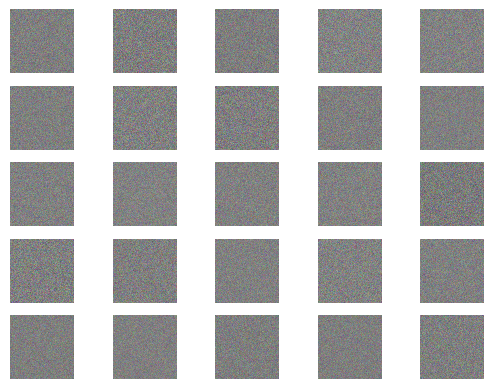

1/1 [==============================] - 0s 26ms/step
50 [D loss: 0.5258, acc.: 92.19%] [G loss: 13.6879]
1/1 [==============================] - 0s 27ms/step


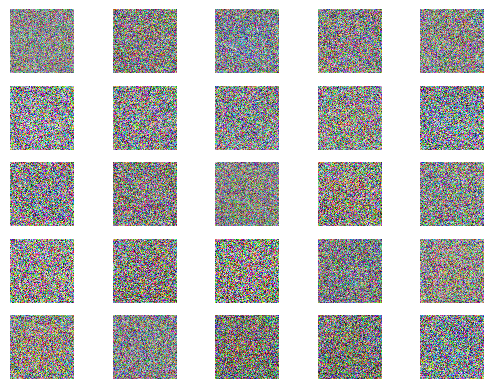

1/1 [==============================] - 0s 26ms/step
100 [D loss: 0.1121, acc.: 98.44%] [G loss: 5.8207]
1/1 [==============================] - 0s 27ms/step


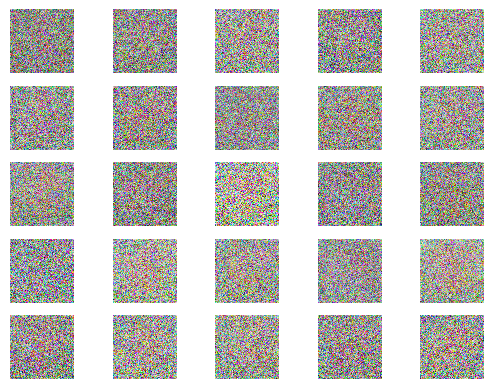

1/1 [==============================] - 0s 26ms/step
150 [D loss: 0.0291, acc.: 100.00%] [G loss: 5.5138]
1/1 [==============================] - 0s 51ms/step


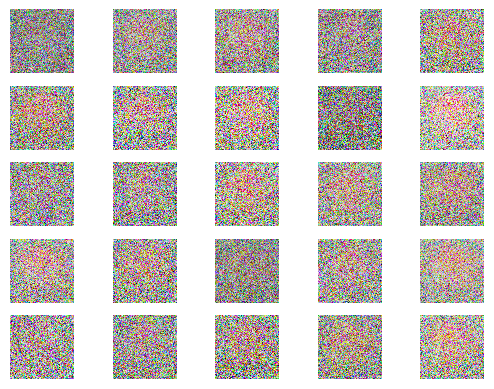

1/1 [==============================] - 0s 28ms/step
200 [D loss: 0.0157, acc.: 100.00%] [G loss: 9.8277]
1/1 [==============================] - 0s 29ms/step


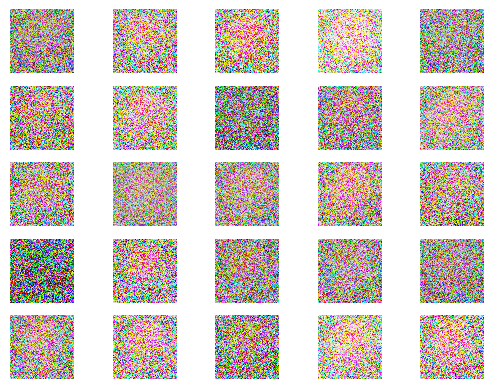

1/1 [==============================] - 0s 27ms/step
250 [D loss: 0.6982, acc.: 78.12%] [G loss: 7.9955]
1/1 [==============================] - 0s 27ms/step


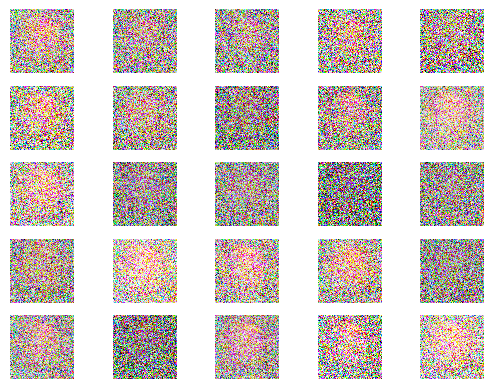

1/1 [==============================] - 0s 27ms/step
300 [D loss: 0.6118, acc.: 70.31%] [G loss: 31.6165]
1/1 [==============================] - 0s 31ms/step


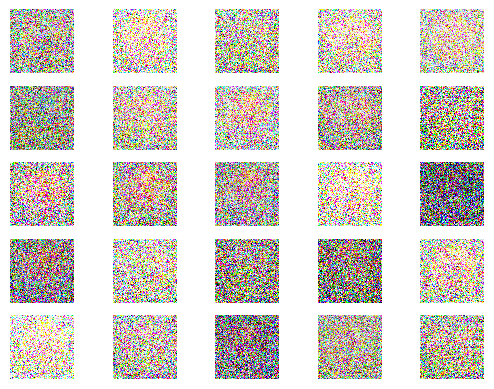

1/1 [==============================] - 0s 27ms/step
350 [D loss: 0.0116, acc.: 100.00%] [G loss: 10.2014]
1/1 [==============================] - 0s 36ms/step


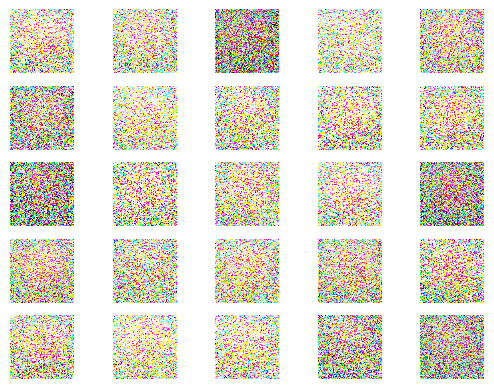

1/1 [==============================] - 0s 28ms/step
400 [D loss: 0.1217, acc.: 98.44%] [G loss: 8.8065]
1/1 [==============================] - 0s 27ms/step


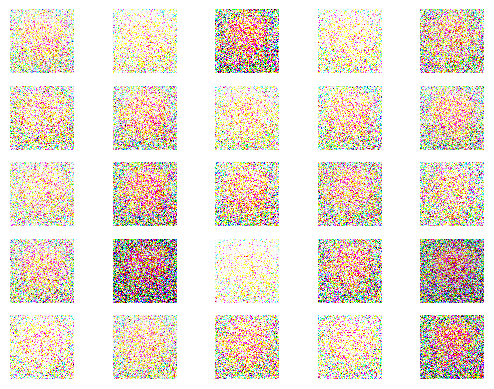

1/1 [==============================] - 0s 26ms/step
450 [D loss: 0.5933, acc.: 81.25%] [G loss: 12.3549]
1/1 [==============================] - 0s 27ms/step


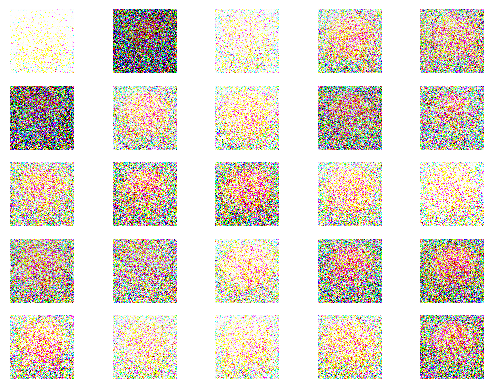

1/1 [==============================] - 0s 28ms/step


In [12]:
train_gan(epochs=500, batch_size=batch_size, sample_interval=50)

In [13]:
def evaluate_generator(num_samples=100):
    noise = np.random.normal(0, 1, (num_samples, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(10, 10, i + 1)
        plt.imshow(gen_imgs[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 40ms/step


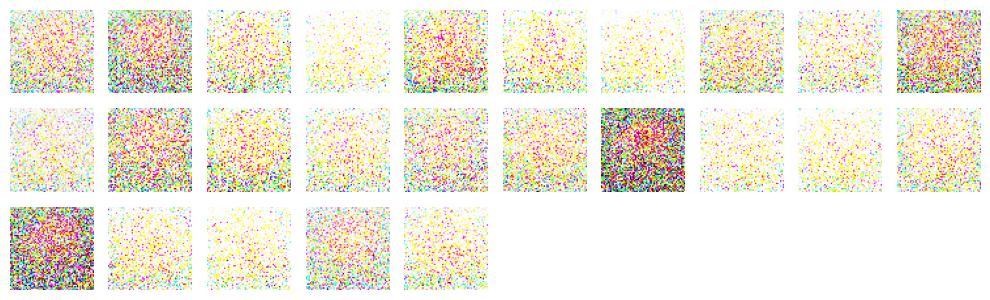

In [14]:
evaluate_generator(num_samples=25)